In [1]:
from pylab import *
from scipy.stats import norm
import csv
import datetime

## Problem 1
### Part A: Time series analysis
The `AMZN` stock prices were obtained [here](https://www.barchart.com/stocks/quotes/AMZN)

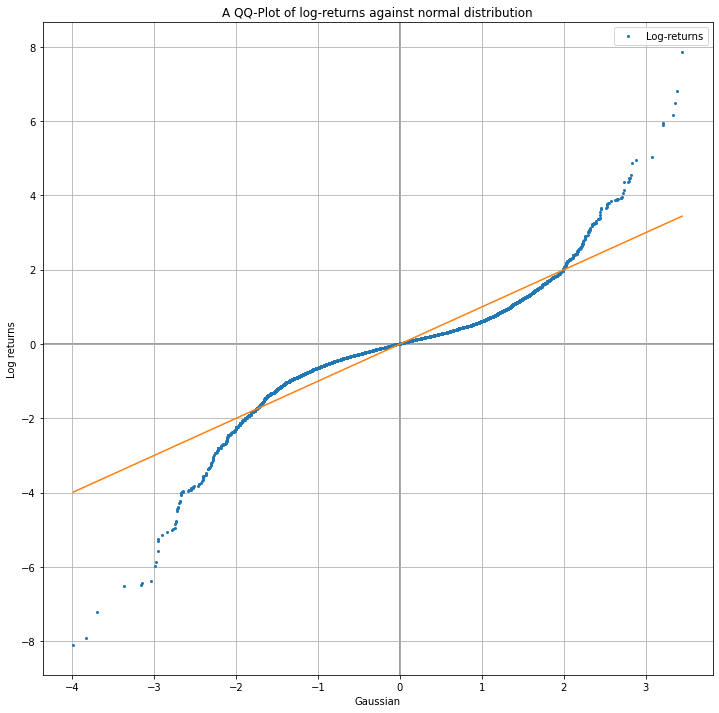

In [2]:
amzn_data = csv.reader(open('amzn_price-history-02-15-2021.csv', 'r'))
pricehist = [row for row in amzn_data]

amzn_prices = [float(row[4]) for row in pricehist[1:]] 
logreturns = diff(log(amzn_prices))

X = (logreturns - mean(logreturns))/std(logreturns)
gauss = normal(size=len(logreturns))

figure(figsize=(12,12))
title('A QQ-Plot of log-returns against normal distribution')
plot(sort(gauss),sort(X),'o',markersize=2, label='Log-returns')
plot(sort(gauss),sort(gauss))
xlabel('Gaussian')
ylabel('Log returns')
grid()
axhline(color='gray', zorder=-1)
axvline(color='gray', zorder=-1)
legend()
show()

The sample points mostly lie close to the line  $y=x$. From this we can conclude that the log-returns are distributed approximately normally, but the central quantiles are less closely spaced. The `AMZN` log-returns are also skewed left relative to the normal distribution. The plot points  diverge significantly from the Gaussian distribution in and beyond the third quantiles, indicating strong price reaction to rare events (e.g. financial crises).

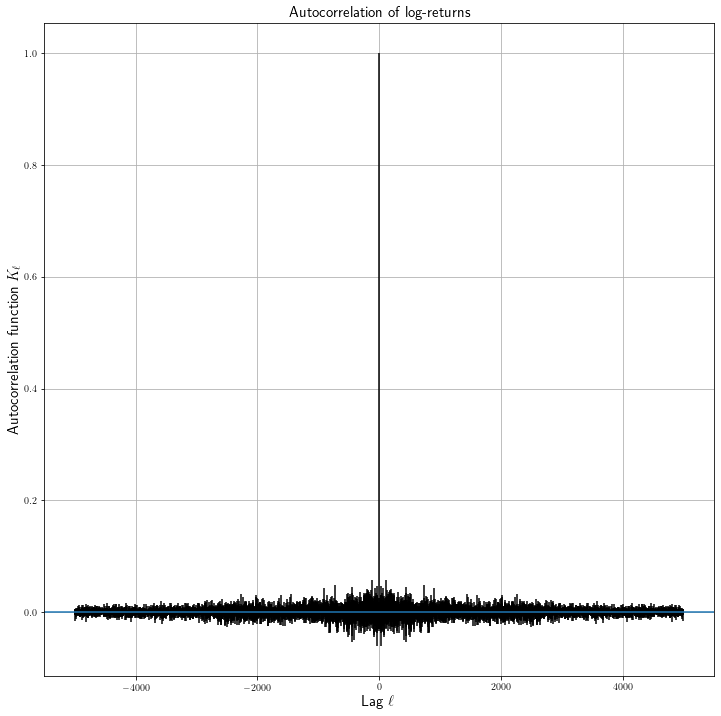

In [3]:
figure(figsize=(12,12))
rc('text', usetex=True)

acorr(logreturns, maxlags=5000)
#xlim([-0.5,1000])

xlabel(r'Lag $\ell$', fontsize=15)
ylabel(r'Autocorrelation function $K_{\ell}$', fontsize=15)
title('Autocorrelation of log-returns', fontsize=15)
grid()

From the graph, the assumption of approximately independently distributed log-returns seems justified.
## Part B
We now estimate the 120- and 180-day volatility, and compare with values obtained [here](https://www.alphaquery.com/stock/AMZN/volatility-option-statistics/180-day/iv-mean).

120-day volatility = 0.3306

180-day volatility = 0.3398

In [4]:
def est_vol(vol_period):
    dates = [row[0] for row in pricehist[1:vol_period]]
    D = datetime.datetime.strptime(dates[0],"%m/%d/%Y") - datetime.datetime.strptime(dates[-1],"%m/%d/%Y")
    T = D.days/365
    
    return std(logreturns[:vol_period-1])/sqrt(T/len(logreturns[:vol_period-1]))
est_vol(120)

0.33575809895532766

In [5]:
est_vol(180)

0.3401312089468232

The estimated volatility approximates the historical volatility closely.
## Part B: Interest rate Interpolation
According to Hull's *Options, Futures and other Derivatives*, under best practice traders do not price derivatives using Treasury rates, (which are usually too low). Instead, rates like LIBOR (or recently SOFR) are used.  However, except under extreme circumstances, option prices are generally far less sensitive to changes in the risk-free interest rate than in other parameters. (Rho is one of the least significant first-order Greeks). So we have simply lifted the [Treasury figures](https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield) into our model with no interpolation.


## Part C: Option Pricing

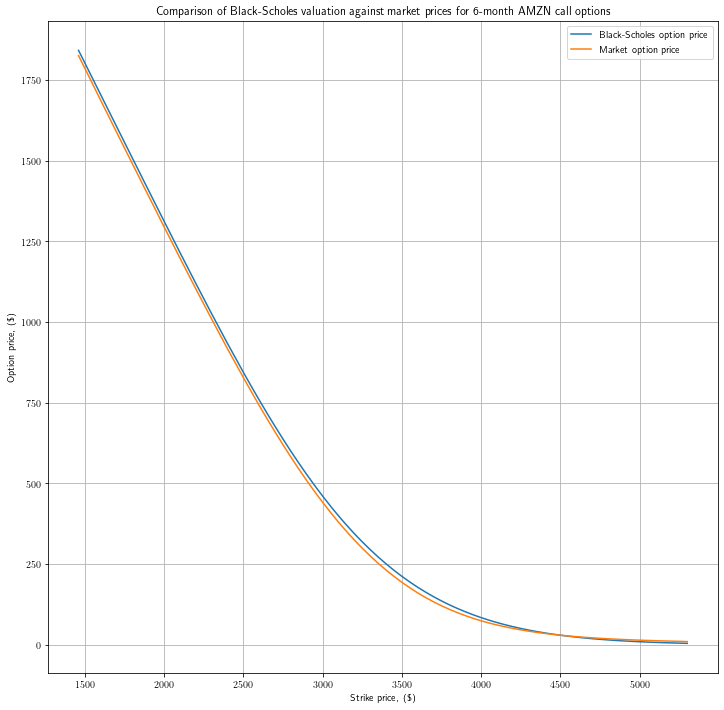

In [114]:
amzn_price = amzn_prices[0]

def black_scholes(r, sigma, S, K, T):
    x = (log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*sqrt(T))
    return S*norm.cdf(x) - K*exp(-r*T)*norm.cdf(x - sigma*sqrt(T))

black_scholes = vectorize(black_scholes)

options1 = csv.reader(open('amzn-options-exp-2021-07-16-monthly-show-all-stacked-02-15-2021.csv', 'r'))
data1 = [row for row in options1]
T1 = (datetime.date(2021, 7,16) - datetime.date(2021, 2,15)).days/365
amzn_sigma1 = 0.3338
amzn_rate1 = 0.04

# Pick out data for call options
strikes1 = [row[2] for row in data1 if row[14] == 'Call']
calls1 = [row[5] for row in data1 if row[14] == 'Call']

# Convert into arrays of floats
strikes1 = array([float(strikes1[i].replace(',','')) for i in range(len(strikes1))]) # remove commas
calls1 = array([float(calls1[i].replace(',','')) for i in range(len(calls1))])

figure(figsize=(12,12))
plot(strikes1, black_scholes(amzn_rate1, amzn_sigma1, amzn_price, strikes1, T1),label="Black-Scholes option price")
plot(strikes1, calls1, label="Market option price")
title('Comparison of Black-Scholes valuation against market prices for 6-month AMZN call options')
xlabel('Strike price, (\$)')
ylabel('Option price, (\$)')
legend()
grid()
show()

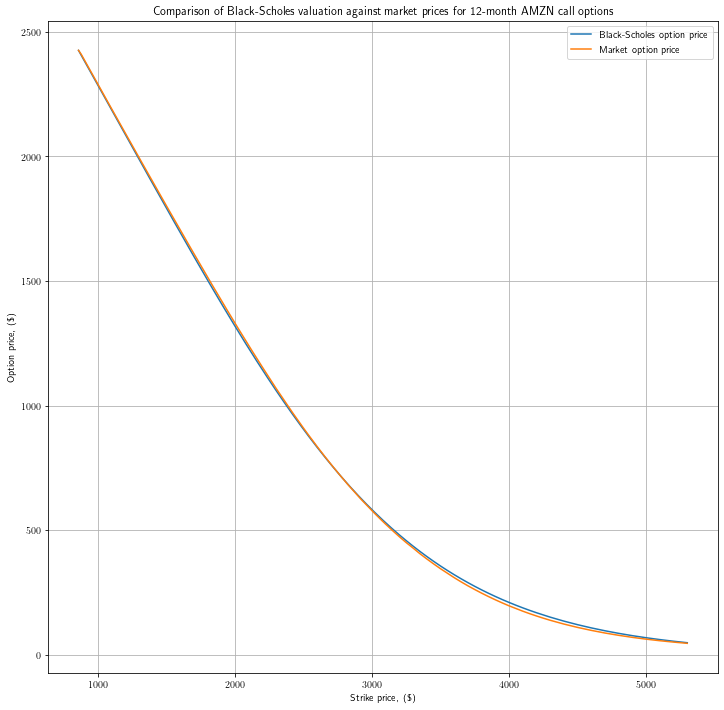

In [116]:
options2 = csv.reader(open('amzn-options-exp-2022-01-21-monthly-show-all-stacked-02-15-2021.csv', 'r'))
data2 = [row for row in options2]

T2 = (datetime.date(2022, 1,21) - datetime.date(2021, 2,15)).days/365
amzn_sigma2 = 0.3439
amzn_rate2 = 0.08

# Pick out data for call options
strikes2 = [row[2] for row in data2 if row[14] == 'Call']
calls2 = [row[5] for row in data2 if row[14] == 'Call'] # using the midpoint of the bid-ask spread

# Convert into arrays of floats
strikes2 = array([float(strikes2[i].replace(',','')) for i in range(len(strikes2))]) # remove commas
calls2 = array([float(calls2[i].replace(',','')) for i in range(len(calls2))])

figure(figsize=(12,12))
plot(strikes2, black_scholes(amzn_rate, amzn_sigma2, amzn_price, strikes2, T2), label='Black-Scholes option price') 
plot(strikes2, calls2, label='Market option price')
title('Comparison of Black-Scholes valuation against market prices for 12-month AMZN call options')
xlabel('Strike price, (\$)')
ylabel('Option price, (\$)')
legend()
grid()
show()

As expected, the Black-Scholes valuation agrees very closely with the given market prices

# Problem 2
See hand-in